In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("12-health_risk_classification.csv")
print(df.columns)
print(df.shape)
print(df.info())
print(df.isnull().sum())
display(df.head())

Index(['bmi_score', 'blood_pressure_variation', 'activity_level_index',
       'high_risk_flag'],
      dtype='object')
(1000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bmi_score                 1000 non-null   float64
 1   blood_pressure_variation  1000 non-null   float64
 2   activity_level_index      1000 non-null   float64
 3   high_risk_flag            1000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 31.4 KB
None
bmi_score                   0
blood_pressure_variation    0
activity_level_index        0
high_risk_flag              0
dtype: int64


,bmi_score,blood_pressure_variation,activity_level_index,high_risk_flag
0,0.564223,0.652825,1.262925,1
1,-1.692569,2.981229,-0.180331,1
2,0.770383,0.400475,1.365806,1
3,2.135007,0.150832,3.084596,0
4,0.360342,1.026132,1.251574,1


In [3]:
df["high_risk_flag"].value_counts()

high_risk_flag
0    502
1    498
Name: count, dtype: int64

In [4]:
# Gayet temiz ve scale edilmiş, dengeli bir veri setimiz var.
# Artık yavaş yavaş kolon dağılımlarını, ilişkileri incelemeye ve modelleme kısmına geçebiliriz.

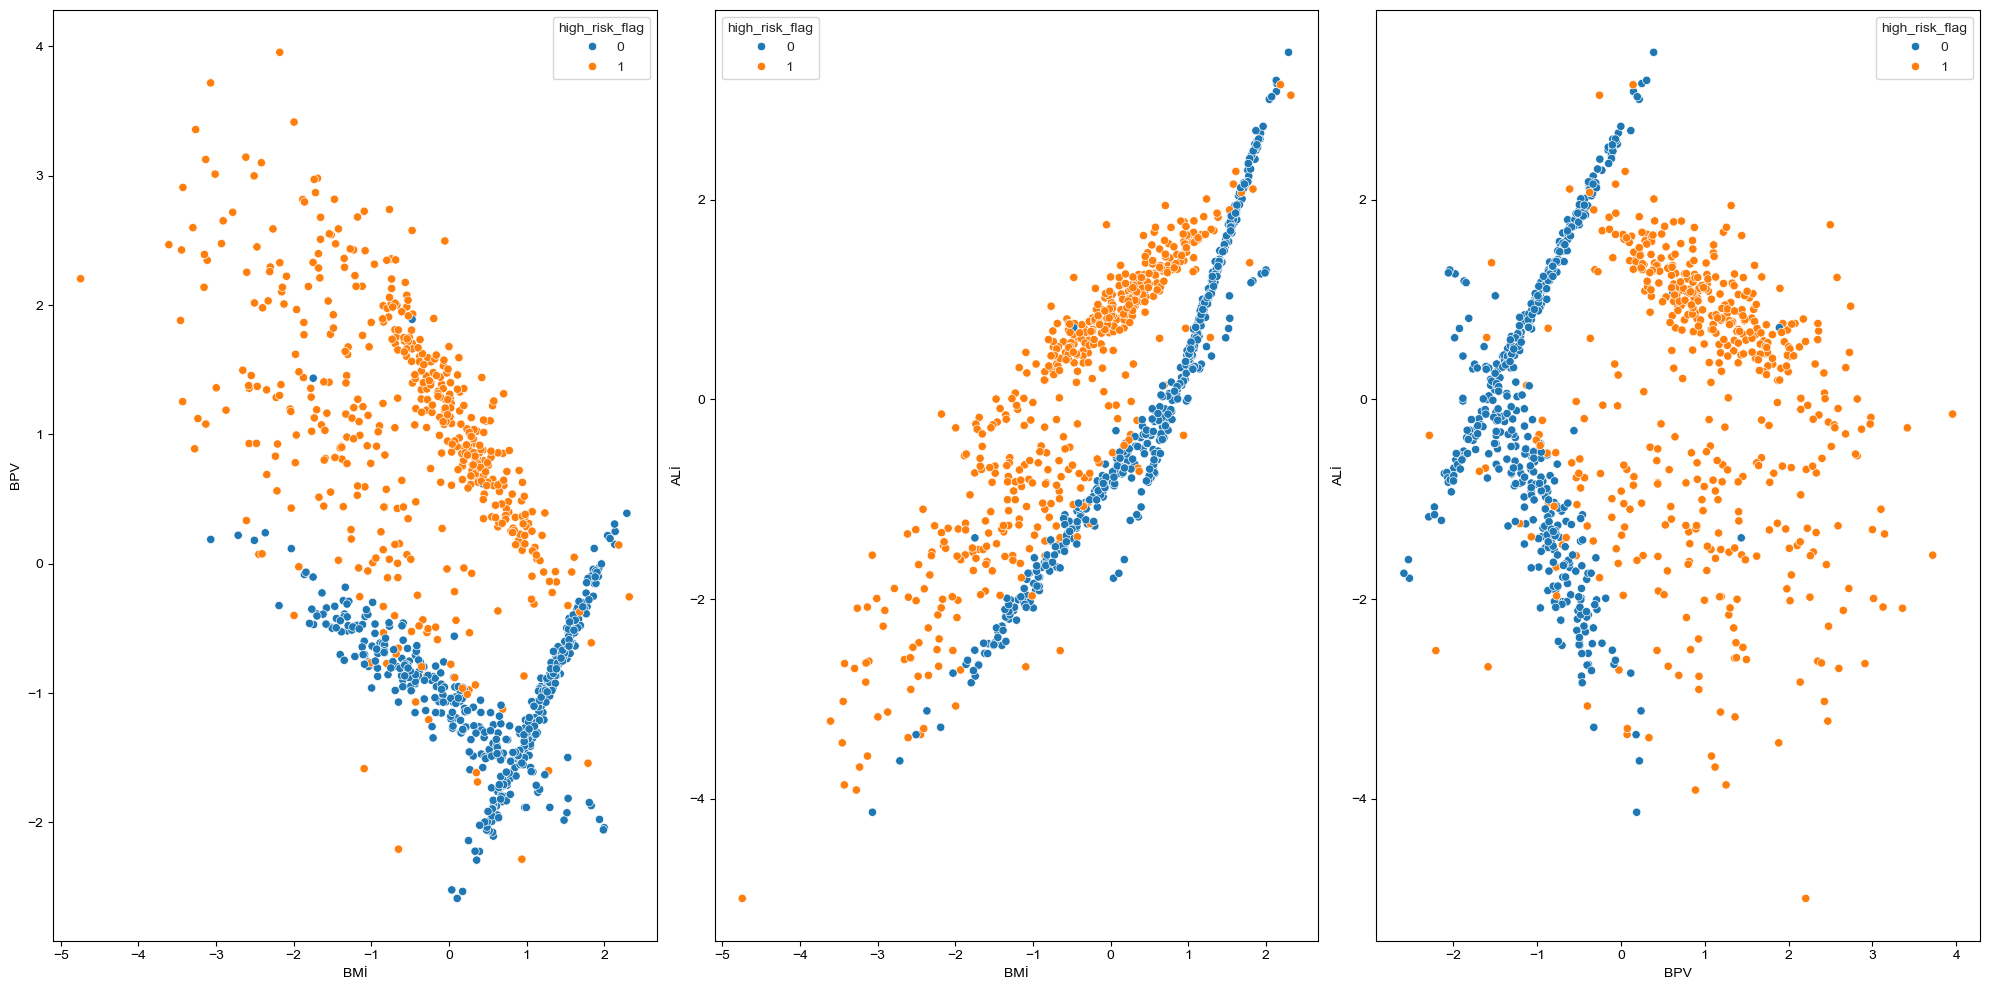

In [5]:
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax = ax.flatten()
sns.set_style("whitegrid")
sns.scatterplot(x="bmi_score", y="blood_pressure_variation", hue="high_risk_flag", data=df, ax=ax[0])
ax[0].set_xlabel("BMİ")
ax[0].set_ylabel("BPV")

sns.set_style("whitegrid")
sns.scatterplot(x="bmi_score", y="activity_level_index", hue="high_risk_flag", data=df, ax=ax[1])
ax[1].set_xlabel("BMİ")
ax[1].set_ylabel("ALİ")

sns.set_style("whitegrid")
sns.scatterplot(x="blood_pressure_variation", y="activity_level_index", data=df, hue="high_risk_flag", ax=ax[2])
ax[2].set_xlabel("BPV")
ax[2].set_ylabel("ALİ")

plt.tight_layout()
plt.show()

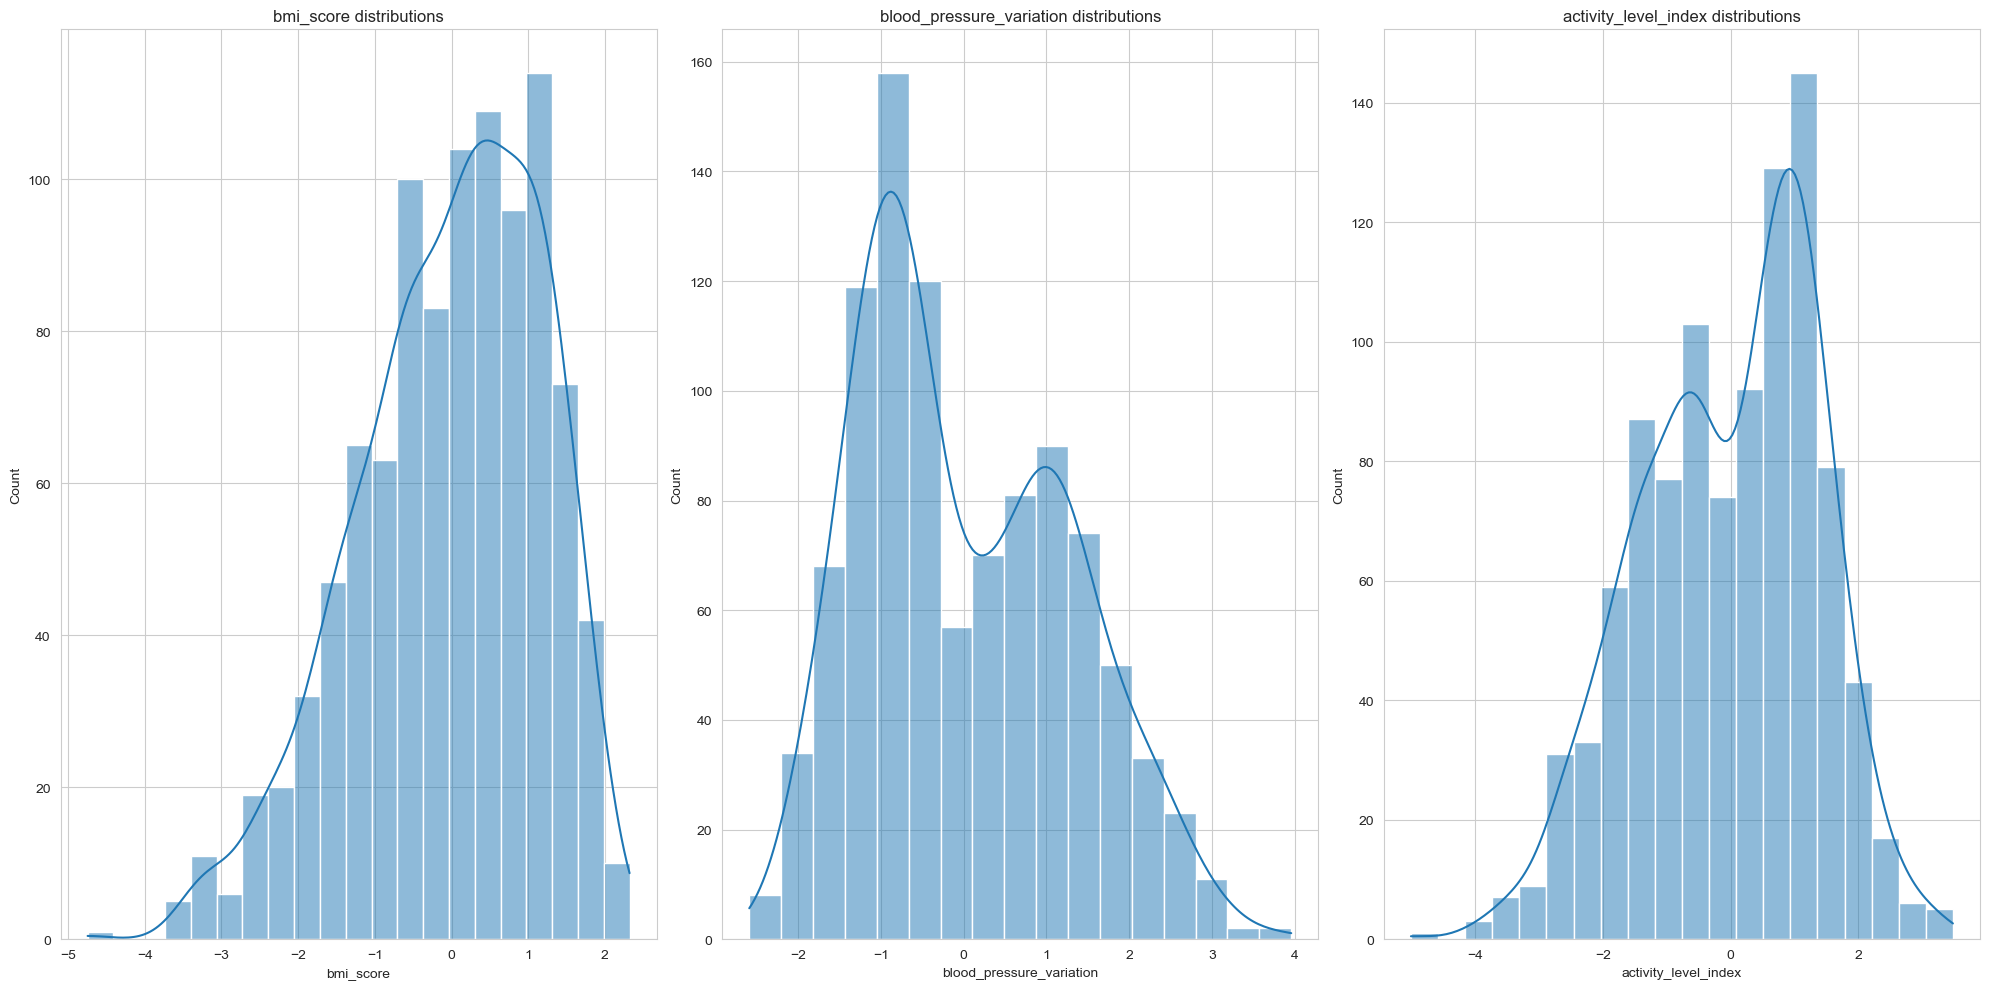

In [6]:
columns = df.drop("high_risk_flag", axis=1).columns
fig1, ax1 = plt.subplots(1,3,figsize=(20,10))
ax1 = ax1.flatten() 

for i, col in enumerate(columns):
    sns.histplot(
        x=col,
        data=df,
        kde=True,
        ax=ax1[i]
    )
    ax1[i].set_title(f"{col} distributions")

plt.tight_layout()
plt.show()

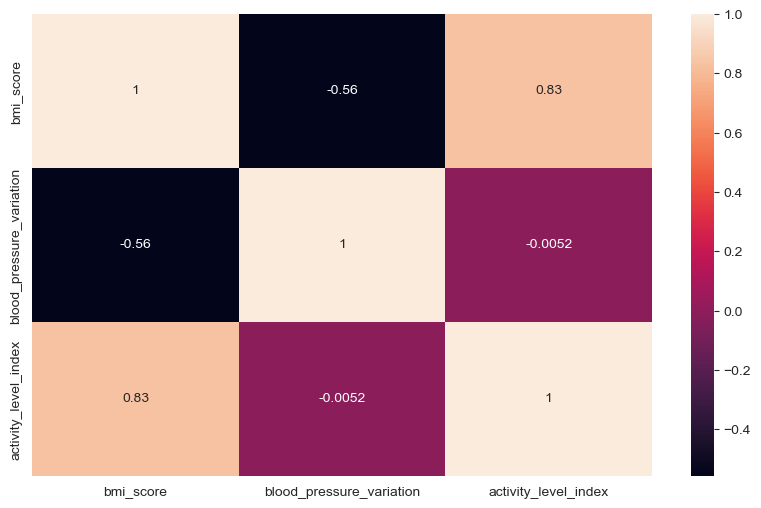

In [7]:
corr = df.drop("high_risk_flag", axis=1).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True)
plt.show()

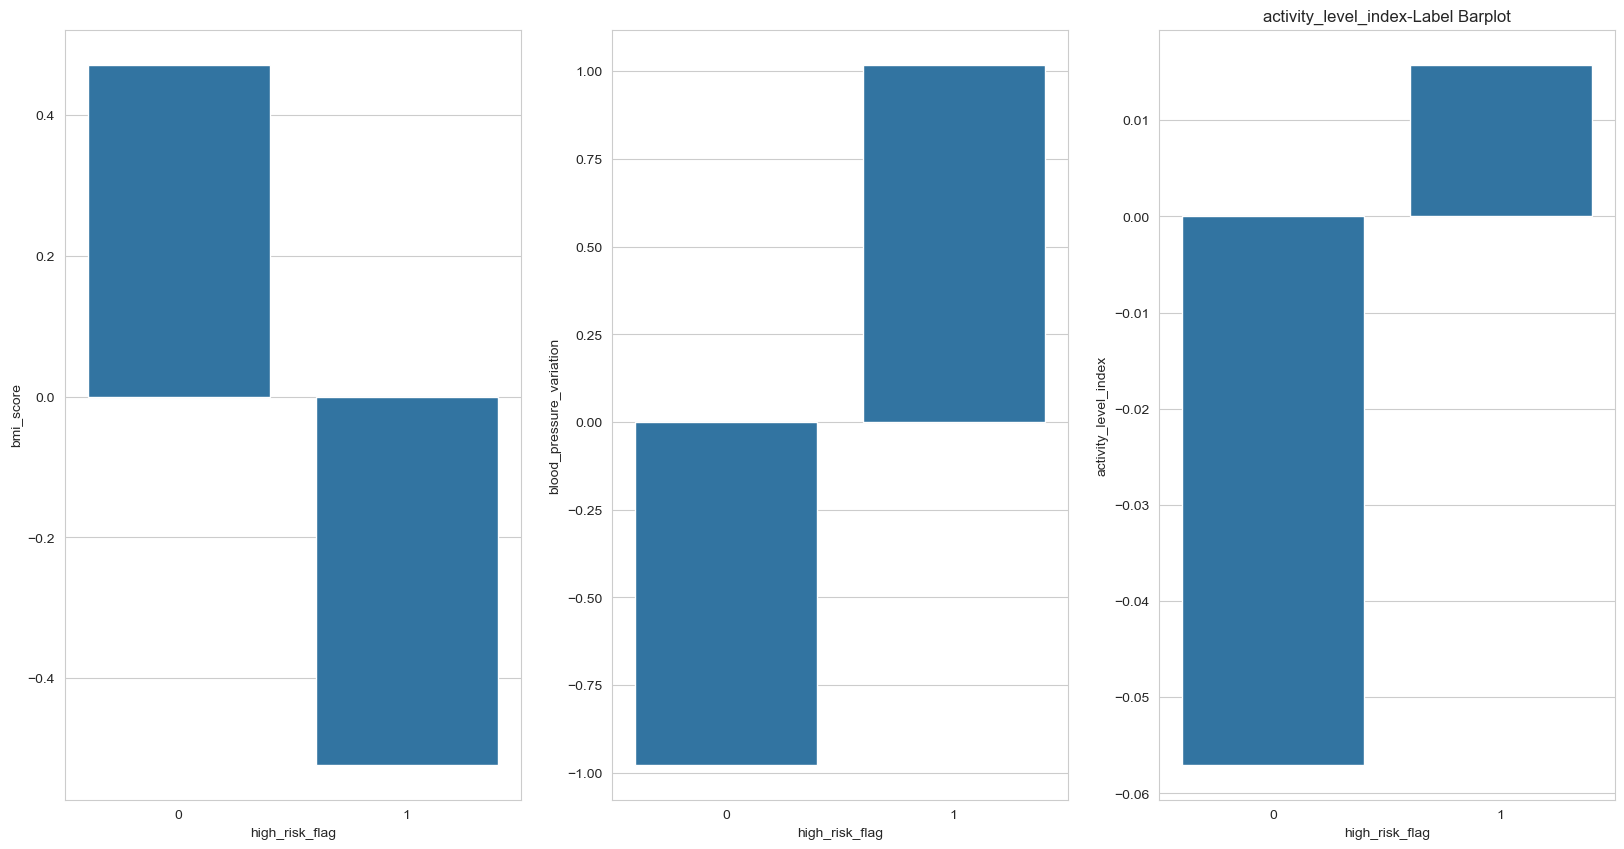

In [8]:
columns = df.drop("high_risk_flag", axis=1)
fig2, ax2 = plt.subplots(1,3,figsize=(20,10))
ax2 = ax2.flatten()
for i, col in enumerate(columns):
    sns.barplot(x="high_risk_flag", 
                y=col, 
                data=df, 
                ax=ax2[i],
                errorbar=None
    )
    plt.title(f"{col}-Label Barplot")

plt.show()

## Model building

In [9]:
from sklearn.model_selection import train_test_split
X = df.drop("high_risk_flag", axis=1)
y = df["high_risk_flag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

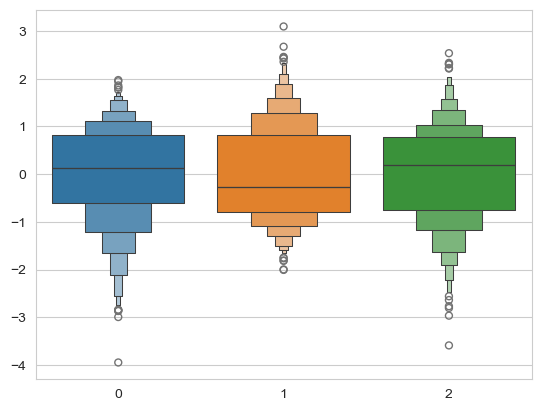

In [11]:
sns.boxenplot(X_train_scaled)
plt.show()

In [12]:
# Eğer continuous(sürekli) verilerle çalışıyorsak verilerimizi scale etmek oldukça önemlidir.
# Decision Tree gibi algoritmalarda ise bu durum pek gerekli değildir. Bunu ağaç yapılarına geldiğimizde anlatacağız.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classifier = KNeighborsClassifier(n_neighbors=5, algorithm="auto", weights="uniform")
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classificaiton Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy Score:  0.952
Classificaiton Report: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       126
           1       0.98      0.92      0.95       124

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Confusion Matrix: 
 [[124   2]
 [ 10 114]]


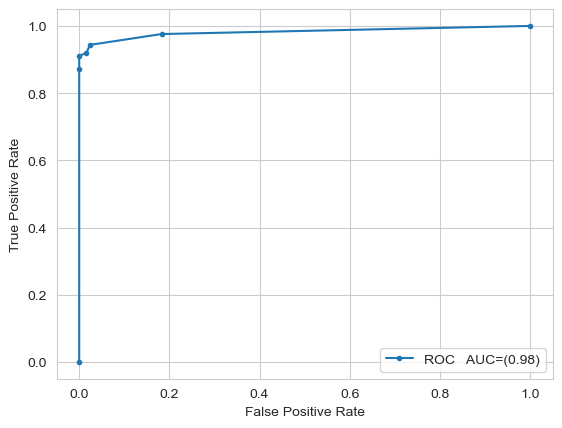

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = classifier.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, marker=".", label=f"ROC   AUC=({auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [15]:
# Modelimizi eğittik ve sonuçları inceleyip şu çıkarımlara ulaşabiliriz:
# Modelimiz gayet iyi ve 0-1 sınıflarını gayet iyi ayırmaktadır.
# Modelin özellikle n_neighbors parametresini değiştirerek farklı sonuçlar elde edebiliriz.

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classifier = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree", weights="uniform")
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classificaiton Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy Score:  0.952
Classificaiton Report: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       126
           1       0.98      0.92      0.95       124

    accuracy                           0.95       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250

Confusion Matrix: 
 [[124   2]
 [ 10 114]]


In [17]:
# Algoritma, weight gibi parametreler daha çok hızı belirler ama model başarımını da etkileyebilir.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classifier = KNeighborsClassifier(n_neighbors=3, algorithm="kd_tree", weights="uniform")
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classificaiton Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy Score:  0.96
Classificaiton Report: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       126
           1       0.99      0.93      0.96       124

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250

Confusion Matrix: 
 [[125   1]
 [  9 115]]


In [19]:
# n_neighbors parametresini değiştirmek model başarımını arttırdı.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
classifier = KNeighborsClassifier(n_neighbors=400, algorithm="kd_tree", weights="uniform")
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Classificaiton Report: \n", classification_report(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Accuracy Score:  0.924
Classificaiton Report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       126
           1       0.98      0.86      0.92       124

    accuracy                           0.92       250
   macro avg       0.93      0.92      0.92       250
weighted avg       0.93      0.92      0.92       250

Confusion Matrix: 
 [[124   2]
 [ 17 107]]


In [21]:
# Fakat n_neighbors parametresinin cıvığını çıkartırsak sonucumuz düşük çıkabilir.
# Bu nedenle ideal sayıyı tutturmak önemlidir.